This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [148]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [193]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1d455666ba0>)

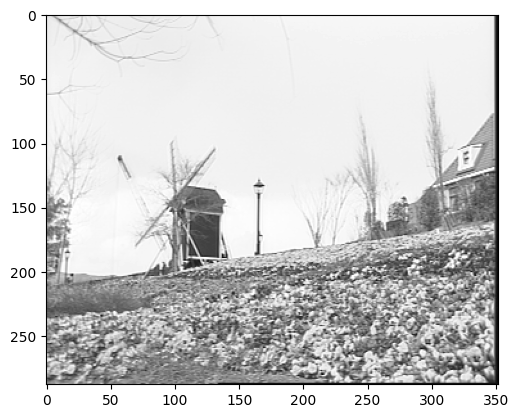

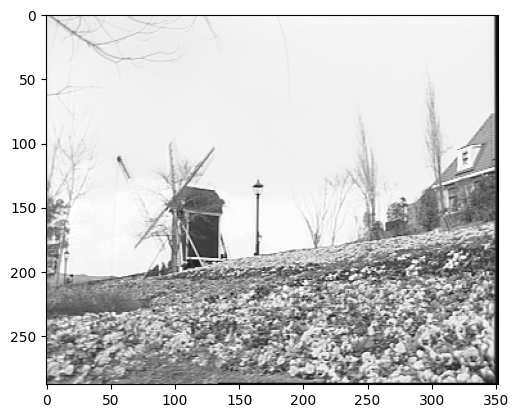

In [150]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [194]:
brow = 16 # Number of rows per block
bcol = 16# Number of columns per block
search_radius = 8 # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [152]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) 
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    #modif: coordonnées de l'image
    H,W = np.shape(cur)[0], np.shape(cur)[1]
    
    # Non-regularized search
    #modif
    if lamb == 0.:
        for p  in range(0,H,brow) : # for each block in the current image, find the best corresponding block in the reference image
            for q in range(0,W,bcol): 
                # current block selection
                B = cur[p:p+brow, q:q+bcol] # Block #modif

                # Initialization:
                
                
                costMin = np.sum((B-ref_extended[p:p+brow,q:q+bcol])**2) # modif
                
                Rbest = ref_extended[p:p+brow,q:q+bcol] # modif
                dcolmin=0
                drowmin=0
              
                
                # Loop on candidate displacement vectors
                for dcol in range(-search, +search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search):# rcol = candidate displacement vector over the rows

                        R=ref_extended[p+search+drow:p+search+drow+brow, q+search+dcol:q+search+dcol+bcol] #pk le +search?
                        
                        cost = np.sum((B - R)**2) # on explore tous les blocs de la fenêtre de recherche  
                        
                        if cost<costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = R
                            dcolmin = dcol
                            drowmin = drow
                            
                mvf[p:p+brow,q:q+bcol,0]= drowmin # Once the loop is over, save the best row displacement field
                mvf[p:p+brow, q:q+bcol,1]= dcolmin# Once the loop is over, save the best column displacement field
                #modif
                r=p
                c=q
                prediction[r:r+brow,c:c+bcol]= Rbest.reshape(brow,bcol)
      
    else: # Regularized search
        for p in range(0,H, brow): # for each block in the current image, find the best corresponding block in the reference image
            for q in range(0,W, bcol):
                # current block selection
                B = cur[p:p+brow, q:q+bcol] # Block

                # Initializations          
                costMin = np.inf # modif
                
                Rbest = ref_extended[p:p+brow,q:q+bcol] # modif
                dcolmin=0
                drowmin=0
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(p,q,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search, search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search): # rcol = candidate displacement vector over the rows
                        d=np.array([drow,dcol])
                        R = ref_extended[p+search+drow: p+search+drow+brow, q+search+dcol : q+search+dcol+bcol] 
                        # distance euclidienne
                        diff = np.sqrt(np.sum((d - pV)**2)) # Regularization term
                        cost = np.sum((B-R)**2) + lamb*diff  # here, encore the REGULARIZED cost function
                        if cost<costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = R
                            dcolmin = dcol
                            drowmin = drow
                
                r=p
                c=q
                mvf[r:r+brow,c:c+bcol,0]= drowmin # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= dcolmin # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=Rbest
                
    
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [153]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

**ANSWER**

- On obtient un champs de vecteur de déplacement cohérent. En effet, la direction et le sens des vecteurs vers la "gauche" est cohérent avec le mouvement entre les deux images ( il y a un décalage vers la gauche entre im1 (cur) et im2(ref)). Les normes faibles des vecteurs traduisent un faible déplacement. Le champ décrit bien la rotation du moulin.

- Il ya des erreurs au niveau du ciel: il y a des zones de forts vecteurs de déplacements au niveau du ciel alors que c'est une zone qui reste constante entre les deux images.

- En modifiant les paramètres ( block size et search area radius) on obtient un champ de vecteurs plus ou moins dense avec des normes plus ou moins grandes. Globalement, on observe toujours les erreurs au niveau du ciel pour toutes les combinaisons de paramètres.


In [154]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

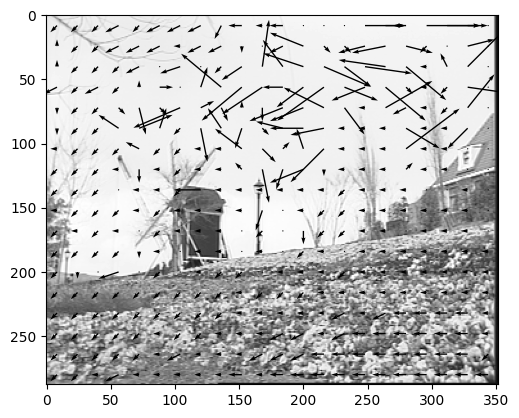

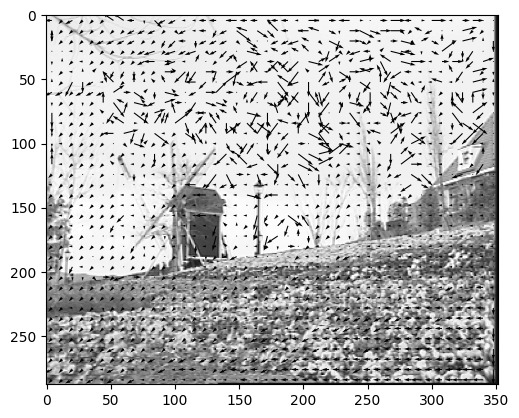

In [155]:
displayMVF(im1,mvf_ssd,brow)

##changement des paramètres (block size et search radius)
brow1 = 8
bcol1 = 8
search_radius1 = 4 
mvf_ssd1,prediction1 =  me_ssd(im2, im1, brow1, bcol1, search_radius1)
displayMVF(im1,mvf_ssd1,brow1)

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

In [156]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1d454b2f080>)

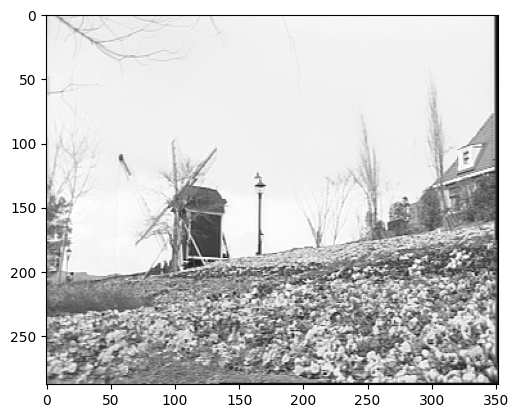

In [157]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

**ANSWER**
On observe peu d'aberrations. En effet les erreurs dans le champ de vecteur de mouvement étaient dans la zone constante du ciel. En comparant avec im1 et im2 on observe que la compensated image obtenue présente un bon compromis en réduisant la différence entre les deux images.

Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

In [158]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    MAX_I = 255
    mse = np.mean((im1-im2)**2)
    psnr = 10*np.log10(MAX_I**2/mse)
                       
    
    return psnr

In [159]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

#btw im1 and im2
psnr_ssd1 = PSNR(im1,im2)
print(psnr_ssd1)

#with different parameters values

mc_ssd1 = fracMc(im1,mvf_ssd1)
psnr_ssd1 = PSNR(im2,mc_ssd1)
print(psnr_ssd1)

16.460078862210647
18.786509322935075
16.444604519219606


**Answer**

PSNR signifie " Peak signal to noise ratio". On a une moins bonne valeur de PSNR (plus petite) entre la motion-compensated image et im2 que entre im1 et im2. Ca devrait être l'inverse: En effet la motion-compensated image est sensée permettre de réduire les différences entre les deux images successives, donc la MSE doit être plus faible que celle entre m1 et m2, donc la PSNR doit être plus grande. Ici ce n'est pas le cas et ça peut peut-être être expliqué par l'absence de régularisation.

En faisant varier les paramètres, on peut obtenir des meilleures valeurs de PSNR.

### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [202]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    H,W = np.shape(cur)[0], np.shape(cur)[1]
    # Non-regularized search
    if lamb == 0.:
         for p  in range(0,H,brow) : # for each block in the current image, find the best corresponding block in the reference image
            for q in range(0,W,bcol): 
                # current block selection
                B = cur[p:p+brow, q:q+bcol] # Block #modif

                # Initialization:
                
                
                costMin = np.sum(np.abs(B-ref_extended[p:p+brow,q:q+bcol])) # modif
                
                Rbest = ref_extended[p:p+brow,q:q+bcol] # modif
                dcolmin=0
                drowmin=0
              
                
                # Loop on candidate displacement vectors
                for dcol in range(-search, +search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search):# rcol = candidate displacement vector over the rows

                        R=ref_extended[p+search+drow:p+search+drow+brow, q+search+dcol:q+search+dcol+bcol] #pk le +search?
                        
                        cost = np.sum(np.abs(B - R)) # on explore tous les blocs de la fenêtre de recherche  
                        
                        if cost<costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = R
                            dcolmin = dcol
                            drowmin = drow
                            
                mvf[p:p+brow,q:q+bcol,0]= drowmin # Once the loop is over, save the best row displacement field
                mvf[p:p+brow, q:q+bcol,1]= dcolmin# Once the loop is over, save the best column displacement field
                #modif
                r=p
                c=q
                prediction[r:r+brow,c:c+bcol]= Rbest.reshape(brow,bcol)
    
                
    else: # Regularized search
        for p in range(0,H, brow): # for each block in the current image, find the best corresponding block in the reference image
            for q in range(0,W, bcol):
                # current block selection
                B = cur[p:p+brow, q:q+bcol] # Block

                # Initializations          
                costMin = np.inf # infini positif
                
                Rbest = None# modif
                dcolmin=0
                drowmin=0
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(p,q,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search, search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search): # rcol = candidate displacement vector over the rows
                        d=np.array([dcol,drow])
                        R = ref_extended[p+search+drow: p+search+drow+brow, q+search+dcol : q+search+dcol+bcol] 
                        # distance en valeur absolue
                        diff = np.linalg.norm(d - pV) # Regularization term 
                        cost = np.sum(np.abs(B-R)) + lamb*diff  # here, encore the REGULARIZED cost function
                        if cost<costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = R
                            dcolmin = dcol
                            drowmin = drow
                
                r=p
                c=q
                mvf[r:r+brow,c:c+bcol,0]= drowmin # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= dcolmin # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=Rbest
                    
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [188]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

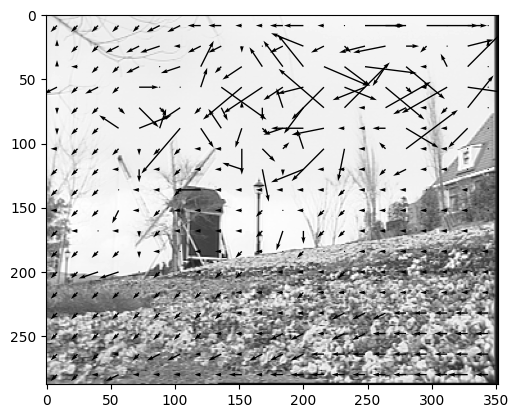

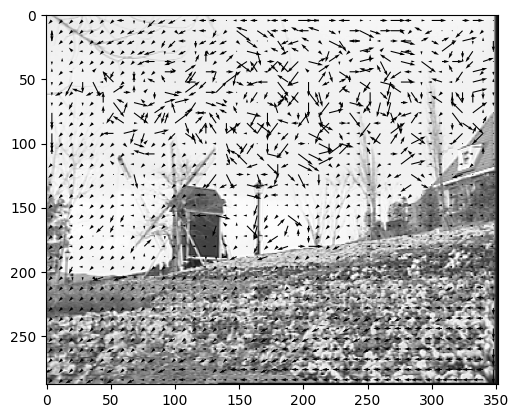

In [162]:
displayMVF(im1,mvf_sad,brow)

# changement des paramètres
brow1 = 8
bcol1 = 8
search_radius1 = 4
mvf_sad1,prediction1 =  me_sad(im2, im1, brow1, bcol1, search_radius1)
displayMVF(im1,mvf_sad1,brow1)

**ANSWER**

On peut remarquer que le champ de vecteurs déplacements reste plus régulier avec ssd que sad, même si l'utilisation de SAD permet de se débarasser de certaines " aberrations" ( vecteurs dans la mauvaise direction ou avec une norme différentes des autres vecteurs de la zone).

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1d446392c60>)

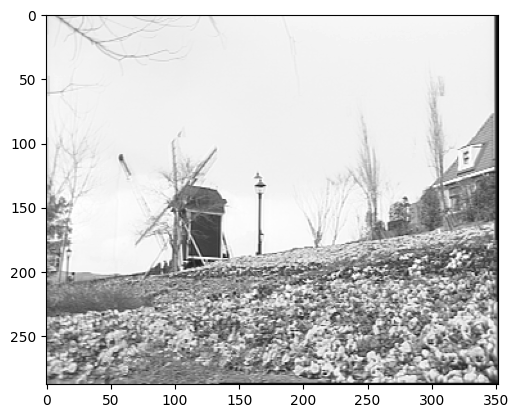

In [163]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [164]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

#en changeant la block size
mc_sad1 = fracMc(im1,mvf_sad1)
psnr_sad1 = PSNR(im2,mc_sad1)
print(psnr_sad1)

16.39966244983968
16.44304204702268


**ANSWER**

- Comme on vient de le voir, le champ obtenu avec SAD permet de se débarraser de quelques aberrations.

- La PSNR entre im2 et la prédiction est très légèrement plus faible que avec SSD (16.40 contre 16.46). On retrouve bien que l'erreur de prédiction est plus importante qu'avec la norme l2.

- L'influence de la  block size est la même que pour SSD, on obtient un champ de vecteurs plus denses et des valeurs de PSNR similaires. 


## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

**ANSWER**
The regularizing function computes the difference of the motion vector (i,j) and a vector representing the neighborhood (regularization vector). The regularization vector is computed by the function computePredictor and is the the median of the mvf of the neighboor blocks. 

When it comes to the results, we find similars values of PSNR(im2,mc_ssd) as with the unregularized algorithm.

for lamb= 0.0001 psnr_ssd = 16.460075158984612
for lamb= 0.001 psnr_ssd = 16.460076675265757
for lamb= 0.01 psnr_ssd = 16.460167069905914
for lamb= 0.1 psnr_ssd = 16.463669619403188
for lamb= 1 psnr_ssd = 16.470441766432756
for lamb= 10 psnr_ssd = 16.470805418824618
for lamb= 20 psnr_ssd = 16.47251506032241
for lamb= 50 psnr_ssd = 16.46268400383829
for lamb= 100 psnr_ssd = 16.468909183898212
for lamb= 0.0001 psnr_ssd = 16.444599870332482
for lamb= 0.001 psnr_ssd = 16.444599870332482
for lamb= 0.01 psnr_ssd = 16.444597894556964
for lamb= 0.1 psnr_ssd = 16.44542024350457
for lamb= 1 psnr_ssd = 16.447833763159146


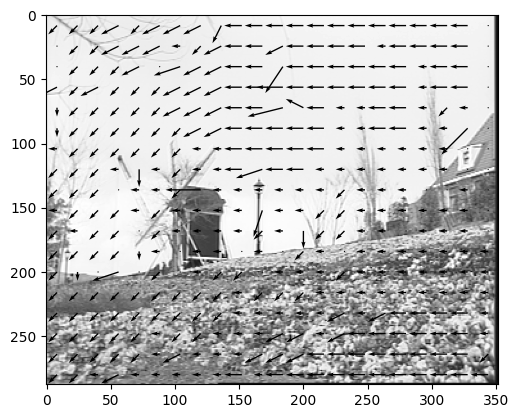

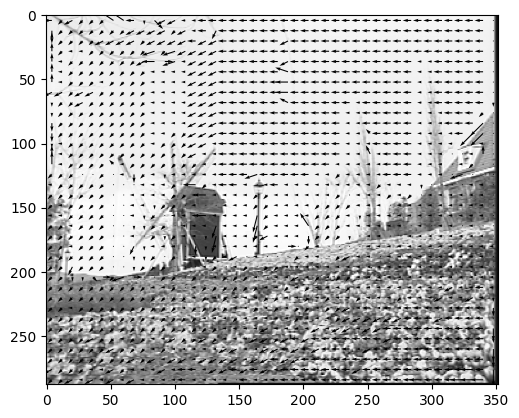

In [ ]:
# Results with the Regularized SSD-based algorithm
lamb = [0.0001,0.001, 0.01, 0.1, 1, 10, 20, 50, 100]
for l in lamb:
    mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius, lamb=l)
    mc_ssd = fracMc(im1,mvf_ssd)
    psnr_ssd = PSNR(im2,mc_ssd)
    print("for lamb=", l,"psnr_ssd =",psnr_ssd)

# results for lamb =0.001
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius, lamb=0.1)
mc_ssd = fracMc(im1,mvf_ssd)
displayMVF(im1,mvf_ssd,brow)

#results with different block size
brow1 = 8
bcol1 = 8
search_radius1 = 4
lamb = [0.0001,0.001, 0.01, 0.1, 1]
for l in lamb:
    mvf_ssd,prediction =  me_ssd(im2, im1, brow1, bcol1, search_radius1, lamb=l)
    mc_ssd = fracMc(im1,mvf_ssd)
    psnr_ssd = PSNR(im2,mc_ssd)
    print("for lamb=", l,"psnr_ssd =",psnr_ssd)
mvf_ssd1,prediction =  me_ssd(im2, im1, brow1, bcol1, search_radius1, lamb=0.001)
mc_ssd1 = fracMc(im1,mvf_ssd)
displayMVF(im1,mvf_ssd,brow1)







### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

for lamb= 0.01 psnr_sad = 16.401534178127637
for lamb= 0.1 psnr_sad = 16.41328679964941
for lamb= 1 psnr_sad = 16.51009132573668
for lamb= 5 psnr_sad = 17.085607267487596
for lamb= 10 psnr_sad = 17.660584266858372
for lamb= 20 psnr_sad = 18.3650546919938
for lamb= 50 psnr_sad = 18.006092727383837
for lamb= 100 psnr_sad = 18.006092727383837


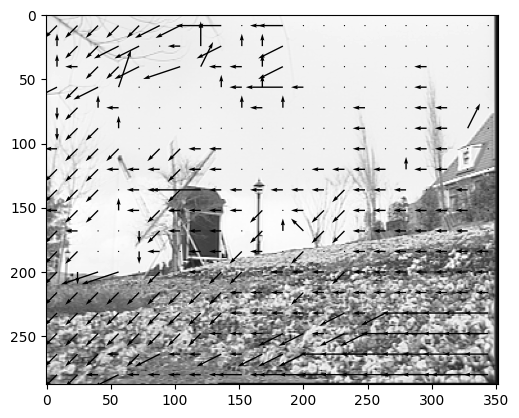

In [ ]:
#results with the Regularized SAD-based algorithm
lamb = [0.01, 0.1, 1, 5, 10, 20, 50, 100]
for l in lamb:
    mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius, lamb=l)
    mc_sad = fracMc(im1,mvf_sad)
    psnr_sad = PSNR(im2,mc_sad)
    print("for lamb=", l,"psnr_sad =",psnr_sad)



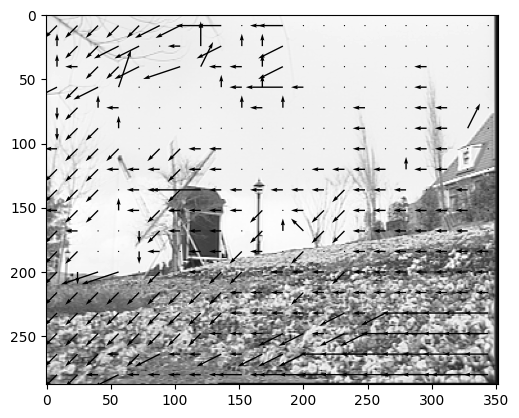

In [204]:
#results for lamb = 0.1

mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius, lamb=0.1)
mc_sad = fracMc(im1,mvf_sad)
displayMVF(im1,mvf_sad,brow)

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [167]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1d44409f590>)

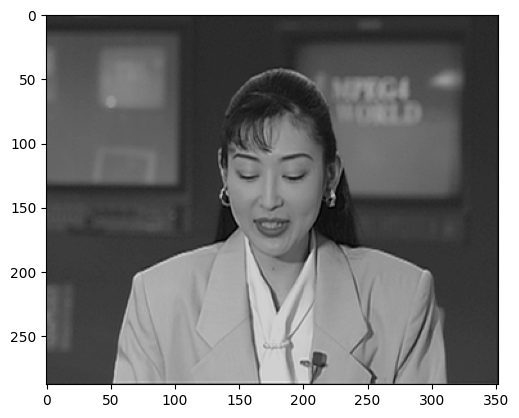

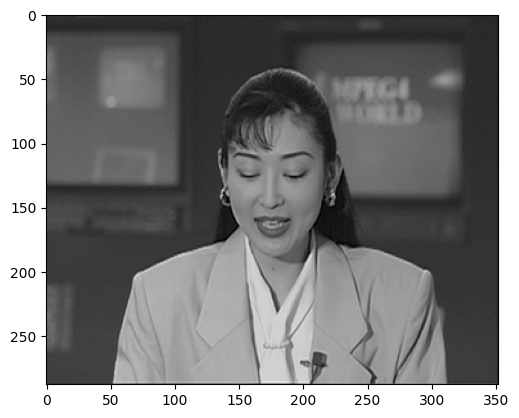

In [168]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [169]:
brow = 16; bcol=16; search_radius =13;
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)





In [170]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg= convolve2d(u,kernel_1,'same')
        vAvg= convolve2d(v,kernel_1,'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx*(uAvg*fx + vAvg*fy + ft)/(alpha**2 +fx**2 + fy**2)
        v = vAvg - fy*(uAvg*fx+vAvg*fy+ft)/(alpha**2 + fx**2 + fy**2)
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [171]:
alpha = 100
ite = 100

uInitial = mvf_ssd[:,:,1] # Rem: pay attention to the inversion of the order compared to me_ssd.
vInitial = mvf_ssd[:,:,0]
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

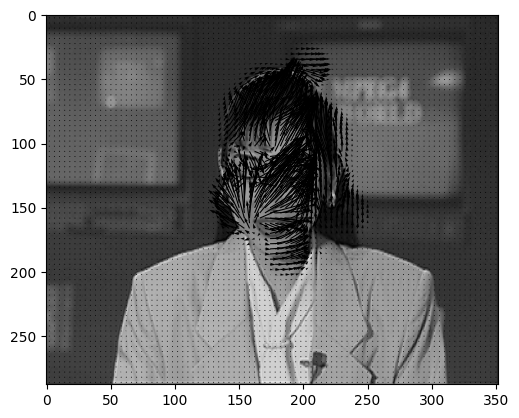

In [172]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [173]:
psnr_hs

35.82907640994765

**ANSWER**
Comparé au Block-matching algorithm, il n'y a pas d'erreurs dans les zones constantes avec des vecteurs aberrants. Le champ est fort uniquement au niveau du visage et du cou et ce sont bien les seules zones en mouvement entre les deux images. 

En effet la contrainte de variation totale permet de bien régulariser le résultat.

La valeur de psnr_hs obtenue est très satisfaisante (>30 Db), bien plus que celles qu'on obtenait avec les algorithmes de Block-matching.